# Notebook to exploring stiching a scrolling feed using OCR results

In [1]:
import sys
import cv2
import numpy as np
import pandas as pd
sys.path.insert(0, "../")
from db import HindsightDB
import utils
import tzlocal
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
db = HindsightDB()

In [3]:
frames = db.get_frames()
frames = utils.add_datetimes(frames)
frames = frames.sort_values(by='datetime_local', ascending=True)

In [4]:
frames['day'] = frames['datetime_local'].dt.floor('D')

In [5]:
yesterday_date = pd.to_datetime(datetime.now().date() - timedelta(days=1)).tz_localize(tzlocal.get_localzone())

In [6]:
recent_df = frames.loc[(frames['day'] > yesterday_date) & (frames['application'] == 'com-twitter-android')] 

In [7]:
recent_df = recent_df.iloc[1:20]

In [8]:
images = [cv2.imread(p) for p in recent_df['path']]

# First find and remove header and footer areas

In [9]:
def find_static_regions(images):
    # Assume images are all the same size and loaded in order (important)
    height, width = images[0].shape[:2]
    # Initialize a difference accumulator array
    accum_diff = np.zeros((height, width), dtype=np.float32)

    # Compute differences between consecutive images
    for i in range(len(images) - 1):
        diff = cv2.absdiff(images[i], images[i+1])
        # Convert diff to grayscale if not already
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # Accumulate the difference in the grayscale plane
        accum_diff += gray_diff.astype(np.float32)

    # Normalize the accumulated differences
    cv2.normalize(accum_diff, accum_diff, 0, 255, cv2.NORM_MINMAX)
    # Threshold to get significant differences
    _, static_mask = cv2.threshold(accum_diff, 1, 255, cv2.THRESH_BINARY_INV)

    return static_mask

In [10]:
def get_top_bottom(static_mask):
    # Project the static mask onto the y-axis to find header/footer
    vertical_projection = np.sum(static_mask, axis=1)
    # Threshold to find significant horizontal extents
    y_indices = np.where(vertical_projection < (0.6 * np.max(vertical_projection)))[0]
    y_indices = y_indices[20:-20]
    top, bottom = y_indices[0], y_indices[-1]
    return top, bottom

In [11]:
static_mask = find_static_regions(images)
top, bottom = get_top_bottom(static_mask=static_mask)
top, bottom

(299, 2170)

In [12]:
cropped_images = [im[top:bottom, :, :] for im in images]

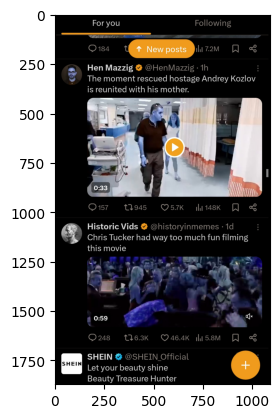

In [13]:
plt.imshow(cropped_images[2])

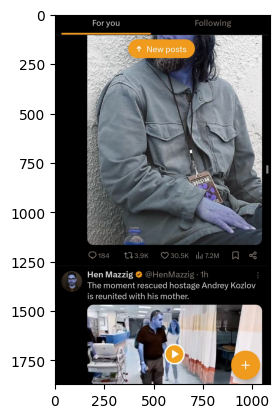

In [14]:
plt.imshow(cropped_images[3])

# Use OCR to match up scrolling images

In [15]:
frames_with_ocr = db.get_frames_with_ocr()
frames_with_ocr = frames_with_ocr.loc[frames_with_ocr['conf'] > 0.7]
frames_with_ocr['y_mid'] = frames_with_ocr['y'] + (frames_with_ocr['h'] / 2)

In [16]:
def mean_within_std(data, num_std=2, points_threshold=3):
    """
    Calculate the mean of values within a certain number of standard deviations.

    Parameters:
        data (list or np.array): The dataset to analyze.
        num_std (int or float): The number of standard deviations to include.

    Returns:
        float: Mean of values within the specified standard deviation range.
    """
    data = np.array(data)  # Ensure data is a NumPy array for vectorized operations.
    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate lower and upper bounds
    lower_bound = mean - num_std * std
    upper_bound = mean + num_std * std

    # Filter data within the specified range
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    # Calculate and return the mean of the filtered data
    if filtered_data.size >= points_threshold:
        return np.mean(filtered_data)
    else:
        return None  # Return None if no data falls within the range

In [17]:
def get_offset(ocr_res, ocr_res_2):
    merged_res = ocr_res.merge(ocr_res_2, on='text')
    merged_res['y_diff'] = merged_res['y_mid_x'] - merged_res['y_mid_y']
    if len(merged_res) == 0:
        return None
    y_offset = mean_within_std(merged_res['y_diff'])
    return y_offset

In [18]:
recent_df_t = recent_df.iloc[:20]

In [19]:
# stitched_image = None
# for i, row in recent_df.iterrows():
#     im = cv2.imread(row['path'])
#     cropped_im = im[top:bottom, :, :]
#     if stitched_image is None:
#         stitched_image = cropped_im
#         last_ocr_res = frames_with_ocr.loc[frames_with_ocr['frame_id'] == row['id']]
#         continue
#     ocr_res = frames_with_ocr.loc[frames_with_ocr['frame_id'] == row['id']]
#     offset = get_offset(last_ocr_res, ocr_res)
#     if offset is None:
#         print("No offset for", row['id'])
#         stitched_image = np.concatenate((stitched_image, cropped_im), axis=0)
#         last_ocr_res = ocr_res
#         continue
    
#     if offset < 20:
#         print("low offset")
#         continue
#     print(offset)
#     stiched_image_height = stitched_image.shape[0]
#     cropped_im_height = cropped_im.shape[0]
#     stitched_image = np.concatenate((stitched_image, cropped_im[int(cropped_im_height-offset):]), axis=0)
#     last_ocr_res = ocr_res

In [20]:
plt.imshow(stitched_image)

NameError: name 'stitched_image' is not defined

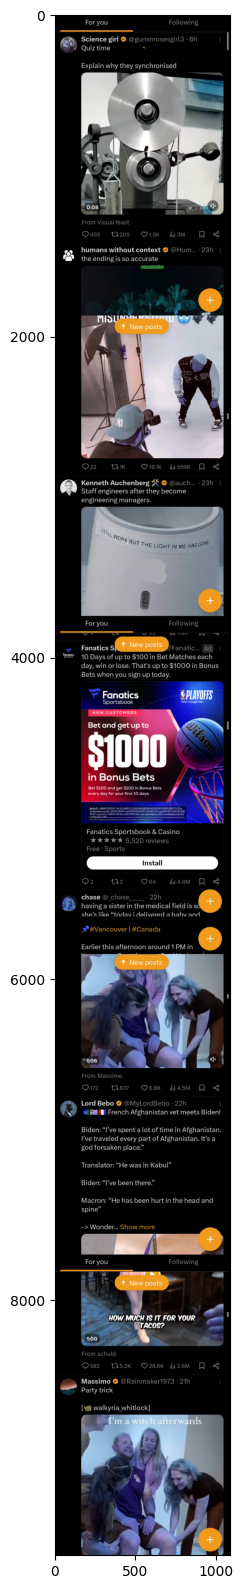

In [ ]:
plt.figure(figsize=(18, 20))
plt.imshow(stitched_image)

In [ ]:
recent_df

,id,timestamp,path,application,datetime_utc,datetime_local,day
70655,70656,1717956547520,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:07.519999981+00:00,2024-06-09 14:09:07.519999981-04:00,2024-06-09 00:00:00-04:00
70732,70733,1717956549565,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:09.565000057+00:00,2024-06-09 14:09:09.565000057-04:00,2024-06-09 00:00:00-04:00
70733,70734,1717956551619,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:11.618999958+00:00,2024-06-09 14:09:11.618999958-04:00,2024-06-09 00:00:00-04:00
70658,70659,1717956553680,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:13.680000067+00:00,2024-06-09 14:09:13.680000067-04:00,2024-06-09 00:00:00-04:00
70657,70658,1717956555746,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:15.746000051+00:00,2024-06-09 14:09:15.746000051-04:00,2024-06-09 00:00:00-04:00
70659,70660,1717956557825,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:17.825000048+00:00,2024-06-09 14:09:17.825000048-04:00,2024-06-09 00:00:00-04:00
70734,70735,1717956559902,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:19.901999950+00:00,2024-06-09 14:09:19.901999950-04:00,2024-06-09 00:00:00-04:00
70663,70664,1717956561954,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:21.953999996+00:00,2024-06-09 14:09:21.953999996-04:00,2024-06-09 00:00:00-04:00
70735,70736,1717956564023,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:24.023000002+00:00,2024-06-09 14:09:24.023000002-04:00,2024-06-09 00:00:00-04:00
70736,70737,1717956566129,/Users/connorparish/code/hindsight/hindsight_s...,com-twitter-android,2024-06-09 18:09:26.128999949+00:00,2024-06-09 14:09:26.128999949-04:00,2024-06-09 00:00:00-04:00


In [21]:
im1 = cv2.imread(recent_df.loc[recent_df['id'] == 70734].iloc[0]['path'])
im2 = cv2.imread(recent_df.loc[recent_df['id'] == 70735].iloc[0]['path'])

In [25]:
stitcher = cv2.Stitcher_create()

In [26]:
ci_t = cropped_images[5:7]

In [27]:
(status, stitched) = stitcher.stitch(ci_t)

: 

In [ ]:
status

1

In [20]:
plt.figure(figsize=(18, 20))
plt.imshow(stitched)

NameError: name 'stitched' is not defined

<Figure size 1800x2000 with 0 Axes>

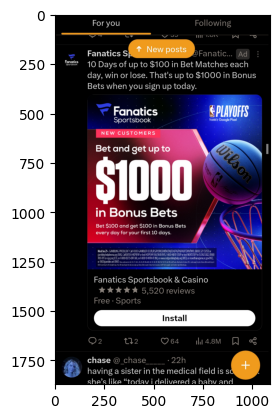

In [22]:
plt.imshow(ci_t[0])

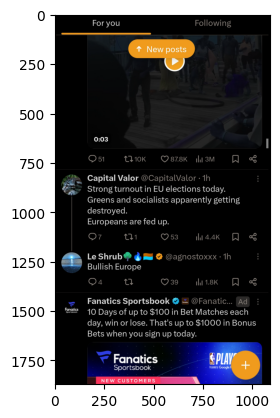

In [23]:
plt.imshow(ci_t[1])